In [33]:
%reload_ext autoreload
%autoreload 2

import os
import sys

import numpy as np
from tqdm import tqdm

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)
import dm21cm.physics as phys

sys.path.append(os.environ['DH_DIR'])

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
from matplotlib.ticker import FixedLocator, FixedFormatter
mpl.rc_file(f"matplotlibrc")

In [5]:
from cooling.rates import *
from cooling.utils import *

In [68]:
#=== common ===
# define grid
Ep_s = np.geomspace(1e2, 1e12, 100)
Eek_s = np.geomspace(1e2, 1e12, 100)
z_s = np.geomspace(5, 45, 100)
rs_s = 1 + z_s
x_ss, y_ss = np.meshgrid(np.log10(Ep_s), np.log10(z_s))

hubble_ss = np.zeros((100, 100))
a_ss      = np.zeros((100, 100))
for i, rs in enumerate(rs_s):
    for j, Ep in enumerate(Ep_s):
        hubble_ss[i,j] = phys.hubble(rs)
        a_ss[i,j] = 1/rs

# conformal dt
cfdt_ss = np.zeros((100, 100))
for i, rs in enumerate(rs_s):
    for j, Eek in enumerate(Eek_s):
        z = rs - 1
        z_next = rs / 1.01 - 1
        cfdt_ss[i,j] = phys.conformal_dx_between_z(z, z_next)

#=== photon ===
# calculate rates
funcs = [pp_CMB_rate, pp_matter_rate, phph_scat_rate, phph_scat_cool_rate, compton_rate, compton_cool_rate, photoion_rate]
phot_rate_ss_dict = {}

for key, xHII in zip(['xHII=1e-4', 'xHII=1-1e-4'], [1e-4, 1-1e-4]):
    phot_rate_ss_dict[key] = []
    for func in funcs:
        name = func.__name__
        print(key, name, flush=True)
        rate_ss = []
        for rs in tqdm(rs_s):
            rate_s = []
            xHeII = xHII * phys.chi
            for Ep in Ep_s:
                rate_s.append(func(Ep, rs, xHII=xHII, xHeII=xHeII))
            rate_ss.append(rate_s)
        phot_rate_ss_dict[key].append(rate_ss)

#=== electron ===
# calculate rates
funcs = [ee_coll_rate, e_ion_rate, e_exc_rate, e_ics_rate]
elec_rate_ss_dict = {}

for key, xHII in zip(['xHII=1e-4', 'xHII=1-1e-4'], [1e-4, 1-1e-4]):
    elec_rate_ss_dict[key] = []
    for func in funcs:
        rate_ss = []
        for rs in rs_s:
            rate_s = []
            for Eek in Eek_s:
                rate_s.append(func(Eek, rs, xHII))
            rate_ss.append(rate_s)
        elec_rate_ss_dict[key].append(rate_ss)

xHII=1e-4 pp_CMB_rate


100%|██████████| 100/100 [00:04<00:00, 20.46it/s]

xHII=1e-4 pp_matter_rate



100%|██████████| 100/100 [00:00<00:00, 501.57it/s]

xHII=1e-4 phph_scat_rate



100%|██████████| 100/100 [00:00<00:00, 8312.47it/s]

xHII=1e-4 phph_scat_cool_rate



100%|██████████| 100/100 [00:00<00:00, 610.94it/s]

xHII=1e-4 compton_rate



100%|██████████| 100/100 [00:01<00:00, 54.17it/s]

xHII=1e-4 compton_cool_rate



100%|██████████| 100/100 [00:02<00:00, 47.94it/s]

xHII=1e-4 photoion_rate



100%|██████████| 100/100 [00:00<00:00, 657.30it/s]

xHII=1-1e-4 pp_CMB_rate



100%|██████████| 100/100 [00:05<00:00, 19.46it/s]

xHII=1-1e-4 pp_matter_rate



100%|██████████| 100/100 [00:00<00:00, 513.06it/s]

xHII=1-1e-4 phph_scat_rate



100%|██████████| 100/100 [00:00<00:00, 8379.22it/s]

xHII=1-1e-4 phph_scat_cool_rate



100%|██████████| 100/100 [00:00<00:00, 603.31it/s]

xHII=1-1e-4 compton_rate



100%|██████████| 100/100 [00:01<00:00, 52.50it/s]

xHII=1-1e-4 compton_cool_rate



100%|██████████| 100/100 [00:02<00:00, 47.18it/s]

xHII=1-1e-4 photoion_rate



100%|██████████| 100/100 [00:00<00:00, 661.95it/s]


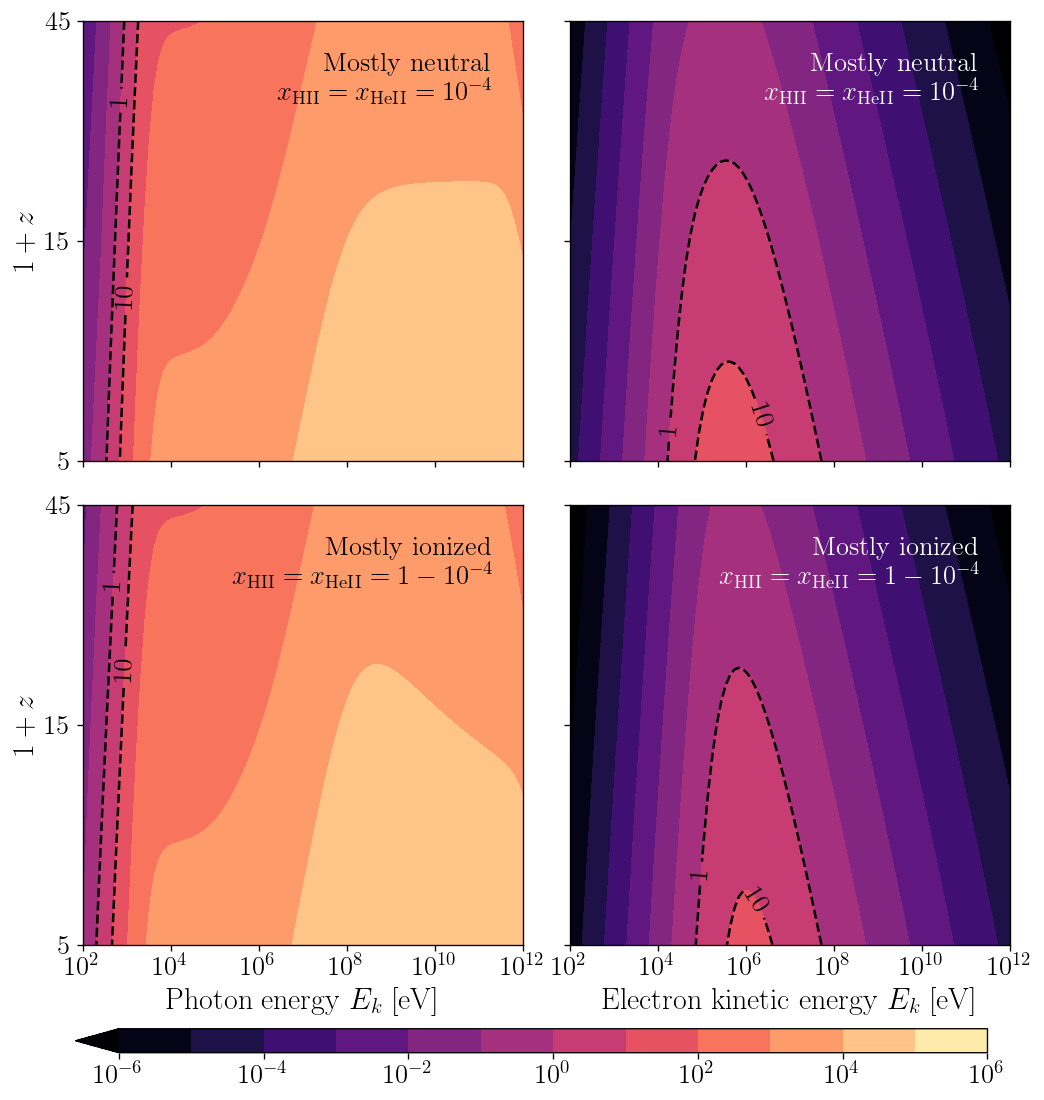

In [74]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex='col', sharey='row')
#fig.subplots_adjust(wspace=0.02, hspace=0.1)

for ik, key in enumerate(['xHII=1e-4', 'xHII=1-1e-4']):

    if ik == 0:
        textstr = 'Mostly neutral\n' + r'$x_\mathrm{HII}=x_\mathrm{HeII}=10^{-4}$'
    else:
        textstr = 'Mostly ionized\n' + r'$x_\mathrm{HII}=x_\mathrm{HeII}=1-10^{-4}$'

    #=== photon ===
    rates = phot_rate_ss_dict[key]
    cfdepth = phys.c / np.clip(np.sum(rates, axis=0), 1e-100, None) / a_ss / phys.Mpc # Mpc
    plot_ss = cfdepth / cfdt_ss

    levels = np.linspace(-6, 6, 13)
    ax = axs[ik, 0]
    im = ax.contourf(x_ss, y_ss, np.log10(plot_ss), cmap='magma', levels=levels, extend='min')
    cs = ax.contour (x_ss, y_ss, np.log10(plot_ss), colors='k', linestyles='--', levels=np.log10([1, 10]), extend='both')
    ax.clabel(cs, cs.levels, fmt={cs.levels[0]: '1', cs.levels[1]: '10'})

    xticks = range_wend(np.min(np.log10(Eek_s)), np.max(np.log10(Eek_s)), 2)
    ax.set_xticks(xticks)
    ax.set_xticklabels(tento_label(xticks))
    ax.set_yticks(np.log10([5, 15, 45]))
    ax.set_yticklabels(['5', '15', '45'])

    if ik == 1:
        ax.set(xlabel=r'Photon energy $E_k$ [eV]')

    ax.text(0.93, 0.93, textstr, transform=ax.transAxes, color='k', ha='right', va='top')
    ax.set(aspect=10/np.log10(45/5))
    ax.set(ylabel=r'$1+z$')

    #=== electron ===
    title = r'Electron cooling time / $\Delta t$'
    
    rates = elec_rate_ss_dict[key]
    gamma = 1 + Eek_s / phys.m_e
    beta = np.sqrt(1 - 1/gamma**2)
    beta = beta[None, :]
    cfdepth = beta * phys.c / np.clip(np.sum(rates, axis=0), 1e-100, None) / a_ss / phys.Mpc # Mpc
    plot_ss = cfdepth / cfdt_ss

    ax = axs[ik, 1]
    im = ax.contourf(x_ss, y_ss, np.log10(plot_ss), cmap='magma', levels=levels, extend='min')
    cs = ax.contour (x_ss, y_ss, np.log10(plot_ss), colors='k', linestyles='--',
                          levels=np.log10([1, 10]), extend='both')
    ax.clabel(cs, cs.levels, fmt={cs.levels[0]: '1', cs.levels[1]: '10'})
    xticks = range_wend(np.min(np.log10(Eek_s)), np.max(np.log10(Eek_s)), 2)
    ax.set_xticks(xticks)
    ax.set_xticklabels(tento_label(xticks))
    ax.set_yticks(np.log10([5, 15, 45]))
    ax.set_yticklabels(['5', '15', '45'])
    if ik == 1:
        ax.set(xlabel=r'Electron kinetic energy $E_k$ [eV]')

    ax.text(0.93, 0.93, textstr, transform=ax.transAxes, color='w', ha='right', va='top')
    ax.set(aspect=10/np.log10(45/5))

fig.subplots_adjust(wspace=0.1, hspace=0.1)

cax = fig.add_axes([0.12, 0.02, 0.76, 0.02]) 
cbar = fig.colorbar(im, cax=cax, spacing='proportional', ticks=range_wend(-6, 6, 2), orientation='horizontal', shrink=0.8, aspect=20)
cbar.ax.set_xticklabels(tento_label(range_wend(-6, 6, 2)))
plt.savefig('cooling.pdf', bbox_inches='tight')